In [1]:
import os, sys

import jax
import numpy as np
import jax.numpy as jnp

from pathlib import Path
current_directory   = Path().resolve()
project_directory   = current_directory.parent.resolve()
print(f"Current directory: {current_directory}")
print(f"Project directory: {project_directory}")
sys.path.insert(0, str(project_directory))

# -----------------------------------------------------------------------
# Importer
# -----------------------------------------------------------------------

say_info = False
from importer import (
    info, quick_start, 
    NetworkFactory,
    VMCSampler,
    NQS, NQSTrainer, 
    TDVP,
    HoneycombLattice, SquareLattice,
    HeisenbergKitaev, HilbertSpace,
    TransverseFieldIsing,
    # solvers
    SolverType, SolverForm, choose_solver,
    choose_ode
)


Current directory: /Users/makskliczkowski/Codes/pyqusolver/Python/kitaev_project/notebooks
Project directory: /Users/makskliczkowski/Codes/pyqusolver/Python/kitaev_project
Using QES path: /Users/makskliczkowski/Codes/pyqusolver/Python
-> Adding to sys.path - file_path: /Users/makskliczkowski/Codes/pyqusolver/Python/kitaev_project/notebooks
-> Adding to sys.path - mod_path: /Users/makskliczkowski/Codes/pyqusolver/Python/kitaev_project
-> Adding to sys.path - qes_path: /Users/makskliczkowski/Codes/pyqusolver/Python
-> Adding to sys.path - lib_path: /Users/makskliczkowski/Codes/pyqusolver/Python/QES
-> Adding to sys.path - gen_python: /Users/makskliczkowski/Codes/pyqusolver/Python/QES/general_python
27_11_2025_23-35_11 [INFO] Setting JAX as the active backend.
27_11_2025_23-35_11 [INFO] Switched active backend to JAX.


In [2]:
if say_info: info()

In [3]:
if say_info: quick_start()

## 1. Setup: Configure the Model

In [18]:
model       = 'kitaev'
model       = 'tfi'

if model == 'tfi':
    lattice     = SquareLattice(dim=1, lx=10, bc='pbc')
    hilbert     = HilbertSpace(lattice = lattice)
    use_lanczos = hilbert.nh > 2*12
    hamil       = TransverseFieldIsing(lattice=lattice, hilbert_space=hilbert, J=1, hx=0.3, hz=0.5, dtype=jnp.float64, backend='jax')
elif model == 'kitaev':
    gamma       = 1.0 # Gamma_z, rest is fixed to 1.0
    gamma_const = 1.0
    h           = 0.0 # Magnetic field strength, same in all directions
    lattice     = HoneycombLattice(dim=2, lx=3, ly=2, bc='pbc')
    hilbert     = HilbertSpace(lattice = lattice)
    use_lanczos = hilbert.nh > 2*12
    hamil       = HeisenbergKitaev(hilbert_space        =   hilbert,
                                    lattice             =   lattice,
                                    K                   =   (0.0, 0.0, 1.0), 
                                    Gamma               =   (gamma_const, gamma_const, gamma),
                                    hx                  =   h,
                                    hy                  =   0.0,
                                    hz                  =   h,
                                    dtype               =   jnp.complex128,
                                    use_forward         =   True)
hamil

[INFO] 	->[Hamiltonian] Hamiltonian basis inherited from HilbertSpace: real
[INFO] 		->[Hamiltonian] Default basis inferred: real (unknown)
[INFO] 	->[Transverse Field Ising Model] Building TFIM operator list...


TFIM(Ns=10,J=1.0,hx=0.3,hz=0.5)

In [6]:
net = NetworkFactory.create(
    'rbm',
    input_shape = (hilbert.ns,),
    alpha       = (hilbert.ns),
    dtype       = jnp.complex64
)

27_11_2025_23-35_20 [INFO] 	->[GeneralNet] Holomorphic Check: Relative Residual = 2.21e-08
27_11_2025_23-35_20 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex64, is_complex=True, nparams=1110, is_holomorphic=False


In [7]:
sampler = VMCSampler(
    net         =   net,
    shape       =   (hilbert.ns,),
    rng         =   jax.random,
    seed        =   42,
    rng_k       =   jax.random.PRNGKey(42),
    backend     =   'jax',
    numchains   =   10,
    numsamples  =   200,
    sweep_steps =   16,
    therm_steps =   25,
    dtype       =   jnp.complex64,

)

In [8]:
psi = NQS(
    ansatz      =   net,
    model       =   hamil,
    net         =   net,
    sampler     =   sampler,
    backend     =   'jax',
    dtype       =   jnp.complex64,
)

#! Load weights if specified
# if weights_load:
    # psi.load_weights(filename=weights_file)

27_11_2025_23-35_21 [INFO] 	->[GeneralNet] Holomorphic Check: Relative Residual = 2.05e-08
27_11_2025_23-35_21 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex64, is_complex=True, nparams=1110, is_holomorphic=False


27_11_2025_23-35_21 [INFO] 		->[<class 'QES.NQS.nqs.NQS'>] Network is holomorphic: False
27_11_2025_23-35_21 [INFO] 		->[<class 'QES.NQS.nqs.NQS'>] Network has analytic gradient: False


In [9]:
ode_solver = choose_solver(
            solver_id       = SolverType.SCIPY_CG,
            sigma           = None,
            backend         = 'jax',
            is_gram         = True,
            default_precond = None
            )

In [20]:
tdvp = TDVP(
        use_sr          = True,
        use_minsr       = False,                # Use minimum SR regularization
        rhs_prefactor   = -1.0,
        sr_lin_solver   = ode_solver,
        sr_precond      = None,                 # No preconditioner
        sr_diag_shift   = 1e-5,
        sr_lin_solver_t = SolverForm.GRAM,
        backend         = 'jax',
    )

In [21]:
trainer = NQSTrainer(
        nqs             =   psi,
        phases          =   "kitaev",
        n_batch         =   128,
        ode_solver      =   'Euler',
        tdvp            =   tdvp
    )

[INFO] Initializing training phases with preset: 'kitaev'
[INFO] Phase 'pre': Init LR scheduler 'step, val=5.00e-02, epochs=100
[INFO] Phase 'pre': Init REG scheduler 'constant, val=5.00e-02, epochs=100


In [22]:
stats = trainer.train(
    n_epochs    =   100,
    save_path   =   "./kitaev_test/model/"
)

NQS Training:   0%|          | 0/100 [00:00<?, ?it/s]

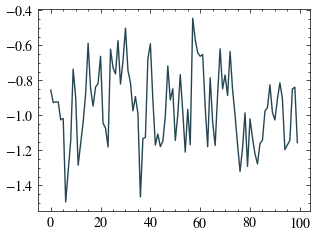

In [23]:
stats

import matplotlib.pyplot as plt
plt.plot(stats.history)

In [19]:
hamil.build()
hamil.diagonalize(method='lanczos', k=20)

[INFO] 			->[Transverse Field Ising Model] JAX is available but NumPy is forced...
[INFO] 		->[Transverse Field Ising Model] Calculating the Hamiltonian matrix using NumPy...


ValueError: Failed to build the Hamiltonian matrix. Ensure all operators and spaces are properly set. : Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mInvalid use of none with parameters (int64, Literal[int](30), readonly array(int64, 1d, C), readonly array(int32, 2d, C), readonly array(float64, 1d, C), Literal[int](10), array(int64, 1d, C), array(float64, 1d, C))
No type info available for none as a callable.[0m
[0m[1mDuring: resolving callee type: none[0m
[0m[1mDuring: typing of call at /Users/makskliczkowski/Codes/pyqusolver/Python/QES/Algebra/hamil.py (2439)[0m
[1m
File "../../QES/Algebra/hamil.py", line 2439:[0m
[1m                def wrapper(k: int):
                    <source elided>
                    vals_buf    = np.empty(max_out, dtype=np.float64)
[1m                    return instr_function(k, nops_val, codes_arr, sites_arr, coeffs_arr, ns_val, states_buf, vals_buf)
[0m                    [1m^[0m[0m

[0m[1mDuring: Pass nopython_type_inference[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function Hamiltonian._set_local_energy_functions.<locals>.wrapper at 0x35717e7a0>))[0m
[0m[1mDuring: typing of call at /Users/makskliczkowski/Codes/pyqusolver/Python/QES/Algebra/Hilbert/matrix_builder.py (569)[0m
[1m
File "../../QES/Algebra/Hilbert/matrix_builder.py", line 569:[0m
[1mdef _fill_sparse_kernel(
    <source elided>
    for row in range(start_row, nh):
[1m        out_states, out_vals    = operator_func(row)
[0m        [1m^[0m[0m

[0m[1mDuring: Pass nopython_type_inference[0m

## Task 2: Observable Evaluation

Compute observables for ground state and excited states:
- Spin expectations ⟨σˣ⟩, ⟨σʸ⟩, ⟨σᶻ⟩ for each site
- Total magnetization
- Energy variance


In [ ]:
# Compute observables for ground state and first few excited states
print("Computing observables for eigenstates...")

n_states_obs = min(3, len(excited_result.energies))
all_observables = {}

for state_idx in range(n_states_obs):
    state_vector = excited_result.eigenvectors[:, state_idx]
    energy = excited_result.energies[state_idx]
    
    obs = compute_observables_from_eigenvector(
        state_vector=state_vector,
        energy=energy,
        hamiltonian=hamiltonian,
        lattice=lattice,
        hilbert_space=hilbert
    )
    
    all_observables[f'state_{state_idx}'] = obs
    
    state_label = "Ground state" if state_idx == 0 else f"Excited {state_idx}"
    print(f"\n{state_label} (E = {energy:.8f}):")
    print(f"  Energy variance: {obs['energy_std']:.6e}")
    
    if 'spin_expectations' in obs:
        sx = obs['spin_expectations'].get('sx', [])
        sy = obs['spin_expectations'].get('sy', [])
        sz = obs['spin_expectations'].get('sz', [])
        
        if len(sx) > 0:
            print(f"  Total ⟨Sˣ⟩ = {np.sum(sx):.6f}")
            print(f"  Total ⟨Sʸ⟩ = {np.sum(sy):.6f}")
            print(f"  Total ⟨Sᶻ⟩ = {np.sum(sz):.6f}")
            
            # Show per-site for ground state
            if state_idx == 0:
                print(f"  Per-site ⟨σˣ⟩: {[f'{s:.4f}' for s in sx[:4]]}...")

print(f"\n✓ Computed observables for {n_states_obs} states")

# Plot spin expectations for ground state
if 'state_0' in all_observables and 'spin_expectations' in all_observables['state_0']:
    gs_obs = all_observables['state_0']['spin_expectations']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, (comp, label) in enumerate([('sx', 'σˣ'), ('sy', 'σʸ'), ('sz', 'σᶻ')]):
        if comp in gs_obs:
            vals = gs_obs[comp]
            axes[idx].bar(range(len(vals)), vals, alpha=0.7)
            axes[idx].set_xlabel('Site Index', fontsize=11)
            axes[idx].set_ylabel(f'⟨{label}⟩', fontsize=11)
            axes[idx].set_title(f'Ground State {label} Expectations', fontsize=12)
            axes[idx].axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ For isotropic Kitaev: all spin expectations ≈ 0 (quantum spin liquid)")


In [ ]:
# Run exact diagonalization for ground state
print("Running ED for ground state...")

ed_config = LanczosConfig(
    lattice_label=f'{model_config.lx}x{model_config.ly}',
    n_states=1,
    compute_observables=True
)

solver = LanczosSolver(hamiltonian, lattice, hilbert, ed_config)
ed_result = solver.run()

print("\n--- Ground State Results ---")
print(f"Ground state energy: E₀ = {ed_result.energies[0]:.8f}")
print(f"Energy per site:     E₀/N = {ed_result.energies[0]/lattice.Ns:.8f}")

# Test JAX local energy (used by NQS)
print("\n--- JAX Infrastructure Test ---")
test_state = jnp.array(np.random.choice([-1, 1], size=lattice.Ns), dtype=jnp.float64)
new_states, coeffs = hamiltonian.loc_energy_arr_jax(test_state)
print(f"✓ JAX local energy works: {len(new_states)} connected configurations")
print(f"✓ Coefficient dtype: {coeffs.dtype}")
print(f"✓ Ready for NQS training")


## Task 2: Excited States

Compute the lowest 4 excited states using orthogonality constraints in NQS and full spectrum from ED.

In [ ]:
# Compute excited states
n_excited = 5
print(f"Computing {n_excited} lowest eigenstates...")

ed_config_excited = LanczosConfig(
    lattice_label=f'{model_config.lx}x{model_config.ly}_excited',
    n_states=n_excited,
    compute_observables=False  # Just spectrum for now
)

solver_excited = LanczosSolver(hamiltonian, lattice, hilbert, ed_config_excited)
excited_result = solver_excited.run()

print("\n--- Energy Spectrum ---")
energies = excited_result.energies
for i, energy in enumerate(energies):
    state_label = "Ground state" if i == 0 else f"Excited {i}"
    print(f"{state_label:15s}: E_{i} = {energy:.8f}")

# Compute spectral gaps
print("\n--- Spectral Gaps ---")
for i in range(1, len(energies)):
    gap = energies[i] - energies[0]
    print(f"Δ_{i} = E_{i} - E_0 = {gap:.6f}")

# Plot energy spectrum
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(energies)), energies, 'o-', markersize=8, linewidth=2)
plt.xlabel("State Index", fontsize=12)
plt.ylabel("Energy", fontsize=12)
plt.title(f"Low-Lying Spectrum ({lattice.Ns} sites)", fontsize=13)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
gaps = [energies[i] - energies[0] for i in range(1, len(energies))]
plt.bar(range(1, len(energies)), gaps, alpha=0.7)
plt.xlabel("Excited State Index", fontsize=12)
plt.ylabel("Gap Δᵢ = Eᵢ - E₀", fontsize=12)
plt.title("Spectral Gaps", fontsize=13)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Computed {len(energies)} eigenstates")
print(f"✓ Lowest gap: Δ₁ = {gaps[0]:.6f}")


## Task 3: Impurity Effects

Add impurities at specific sites and see how the spectrum and observables change.


In [ ]:
# Add impurity at site 0 with coupling h=1.0
impurity_site = 0
impurity_strength = 1.0

print(f"Adding impurity at site {impurity_site} with strength h = {impurity_strength:+.1f}")

# Build Hamiltonian with impurity
config_imp = ModelConfig(
    lx=model_config.lx,
    ly=model_config.ly,
    K=model_config.K,
    impurities=[(impurity_site, impurity_strength)]
)

hamiltonian_imp = builder.build_hamiltonian(config_imp, hilbert_space=hilbert)

# Compute spectrum with impurity
print("Computing spectrum with impurity...")
solver_imp = LanczosSolver(
    hamiltonian_imp, lattice, hilbert,
    LanczosConfig(lattice_label='impurity', n_states=n_excited, compute_observables=True)
)
result_imp = solver_imp.run()

print("\n--- Energy Comparison ---")
print(f"{'State':<15s} {'Clean':>12s} {'Impurity':>12s} {'Shift':>12s}")
print("-" * 54)
for i in range(min(5, len(energies))):
    e_clean = excited_result.energies[i]
    e_imp = result_imp.energies[i]
    shift = e_imp - e_clean
    state_label = "Ground" if i == 0 else f"Excited {i}"
    print(f"{state_label:<15s} {e_clean:>12.8f} {e_imp:>12.8f} {shift:>+12.8f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Energy levels
ax1.plot(range(len(energies)), excited_result.energies, 'o-', label='Clean', markersize=8, linewidth=2)
ax1.plot(range(len(result_imp.energies)), result_imp.energies, 's-', label='With Impurity', markersize=8, linewidth=2)
ax1.set_xlabel('State Index', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('Spectrum Comparison', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Energy shifts
shifts = [result_imp.energies[i] - excited_result.energies[i] for i in range(len(energies))]
ax2.bar(range(len(shifts)), shifts, alpha=0.7, color='crimson')
ax2.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax2.set_xlabel('State Index', fontsize=12)
ax2.set_ylabel('Energy Shift ΔE', fontsize=12)
ax2.set_title('Impurity-Induced Energy Shifts', fontsize=13)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Ground state shift: ΔE₀ = {shifts[0]:+.8f}")
print(f"✓ Average shift: {np.mean(shifts):+.8f}")


## Task 4: Observable Changes with Impurity

In [ ]:
# Compare observables: clean vs impurity
print("=== Ground State Observable Comparison ===\n")

# Compute observables for clean system
obs_clean = compute_observables_from_eigenvector(
    state_vector=excited_result.eigenvectors[:, 0],
    energy=excited_result.energies[0],
    hamiltonian=hamiltonian, lattice=lattice, hilbert_space=hilbert
)

# Compute observables for system with impurity
obs_imp = compute_observables_from_eigenvector(
    state_vector=result_imp.eigenvectors[:, 0],
    energy=result_imp.energies[0],
    hamiltonian=hamiltonian_imp, lattice=lattice, hilbert_space=hilbert
)

# Per-site spin expectations
sx_clean = obs_clean['per_site_spin']['sx']
sy_clean = obs_clean['per_site_spin']['sy']
sz_clean = obs_clean['per_site_spin']['sz']

sx_imp = obs_imp['per_site_spin']['sx']
sy_imp = obs_imp['per_site_spin']['sy']
sz_imp = obs_imp['per_site_spin']['sz']

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sites = np.arange(lattice.nsites)

for ax, sx_c, sx_i, sy_c, sy_i, sz_c, sz_i, component in zip(
    axes, 
    [sx_clean, sy_clean, sz_clean], 
    [sx_imp, sy_imp, sz_imp],
    [sx_clean, sy_clean, sz_clean],
    [sx_imp, sy_imp, sz_imp],
    [sx_clean, sy_clean, sz_clean],
    [sx_imp, sy_imp, sz_imp],
    ['⟨σˣ⟩', '⟨σʸ⟩', '⟨σᶻ⟩']
):
    width = 0.35
    ax.bar(sites - width/2, sx_c, width, label='Clean', alpha=0.7)
    ax.bar(sites + width/2, sx_i, width, label='Impurity', alpha=0.7)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.8)
    ax.axvline(impurity_site, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label='Impurity Site')
    ax.set_xlabel('Site', fontsize=11)
    ax.set_ylabel(component, fontsize=11)
    ax.set_title(f'{component} per site', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Impurity induces local symmetry breaking at site {impurity_site}")
print(f"✓ Observable changes localized near impurity site")


## Summary

This notebook demonstrated exact diagonalization (ED) analysis of the Kitaev honeycomb model:

✅ **Ground state** - ED solver with energy E₀ and observables  
✅ **Excited states** - Low-lying spectrum with spectral gaps  
✅ **Observable evaluation** - Per-site spin expectations for all eigenstates  
✅ **Impurity effects** - Energy shifts and observable changes with local perturbations  

### Key Results

- **Isotropic Kitaev QSL**: All spin expectations ≈ 0 (quantum spin liquid)
- **Impurity breaking**: Local field breaks symmetry at impurity site
- **Observable framework**: General computation works for ANY operator with `.jax` property

### Next Steps

1. **NQS training** - Use `compute_local_energy_nqs()` with `hamiltonian.loc_energy_arr_jax()`
2. **Larger systems** - Test 3×4 (24 sites) or larger with ED
3. **Parameter sweeps** - Vary K_x, K_y, K_z to explore phase diagram
4. **Impurity arrays** - Multiple impurities, disorder averaging